## Step 1: Generate Historical Data
Create 6 months of hourly hotel patterns at Wynn resort and casino

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Create datetime range
dates = pd.date_range(end=datetime.now(), periods=180*24, freq='h')
df = pd.DataFrame({'datetime': dates})

# Extract time features
df['hour'] = df.datetime.dt.hour
df['day'] = df.datetime.dt.dayofweek
df['weekend'] = (df.day >= 4).astype(float)


# Rooms 0-100 -- 85% weekend avg, 70% weekday avg, peaks at night
df['rooms'] = np.where(df.weekend, 
                        85 + 10 * np.sin(2 * np.pi * df.hour / 24),
                        70 + 15 * np.sin(2 * np.pi * df.hour / 24))

# Cleaning 0-160+ -- Peaks 10am-2pm (checkout) and 6-8pm (turndown)
df['cleaning'] = np.where((df.hour >= 10) & (df.hour <= 14), 
                            80 + df.rooms * 0.8,
                            np.where((df.hour >= 18) & (df.hour <= 20),
                                    40 + df.rooms * 0.3,
                                    20 + df.rooms * 0.1))

# Security 0-75 -- Higher at night (10pm-4am), extra on weekends
df['security'] = np.where((df.hour >= 22) | (df.hour <= 4),
                            40 + df.weekend * 20 + 10,
                            20 + df.weekend * 10 + 5)


# Add noise
df['rooms'] = np.clip(df.rooms + np.random.normal(0, 5, len(df)), 0, 100)
df['cleaning'] = np.clip(df.cleaning + np.random.normal(0, 10, len(df)), 0, None)
df['security'] = np.clip(df.security + np.random.normal(0, 5, len(df)), 0, None)
    

historical_data = df[['datetime', 'rooms', 'cleaning', 'security']]

print(f"Total hours: {len(historical_data)}")
print(historical_data)



Total hours: 4320
                       datetime       rooms    cleaning   security
0    2024-12-23 07:05:13.014015   75.963843   32.319546  27.952982
1    2024-12-23 08:05:13.014015   75.227123   24.065082  30.240467
2    2024-12-23 09:05:13.014015   78.217368   35.114847  27.890272
3    2024-12-23 10:05:13.014015   72.586916  134.904046  23.405340
4    2024-12-23 11:05:13.014015   75.682507  130.763650  22.826410
...                         ...         ...         ...        ...
4315 2025-06-21 02:05:13.014015   90.394490   31.684491  67.577942
4316 2025-06-21 03:05:13.014015   89.479336   27.572682  83.757386
4317 2025-06-21 04:05:13.014015  100.000000   27.118664  63.464629
4318 2025-06-21 05:05:13.014015  100.000000   30.864423  30.384129
4319 2025-06-21 06:05:13.014015   93.755614   12.738746  36.899382

[4320 rows x 4 columns]


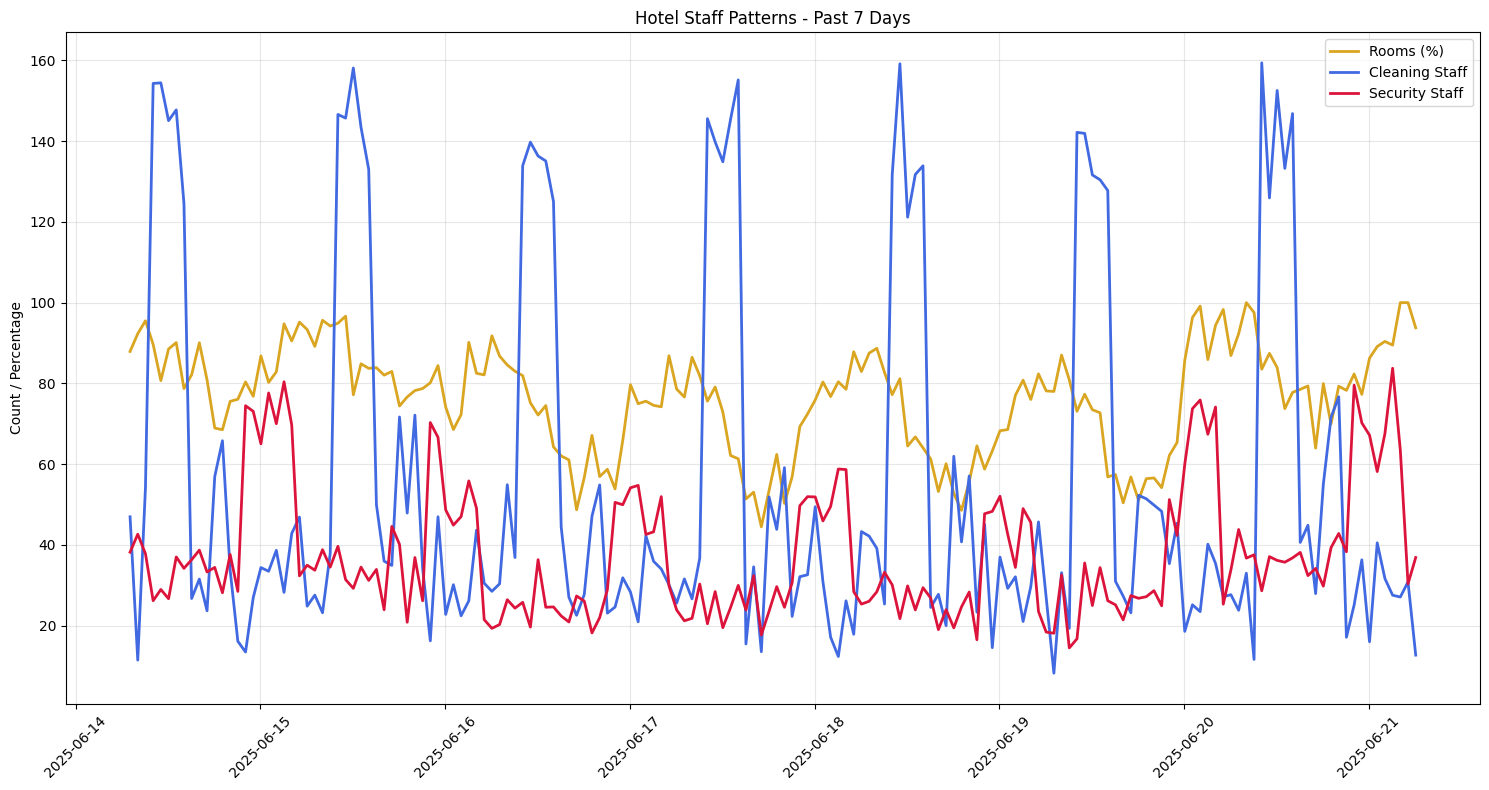

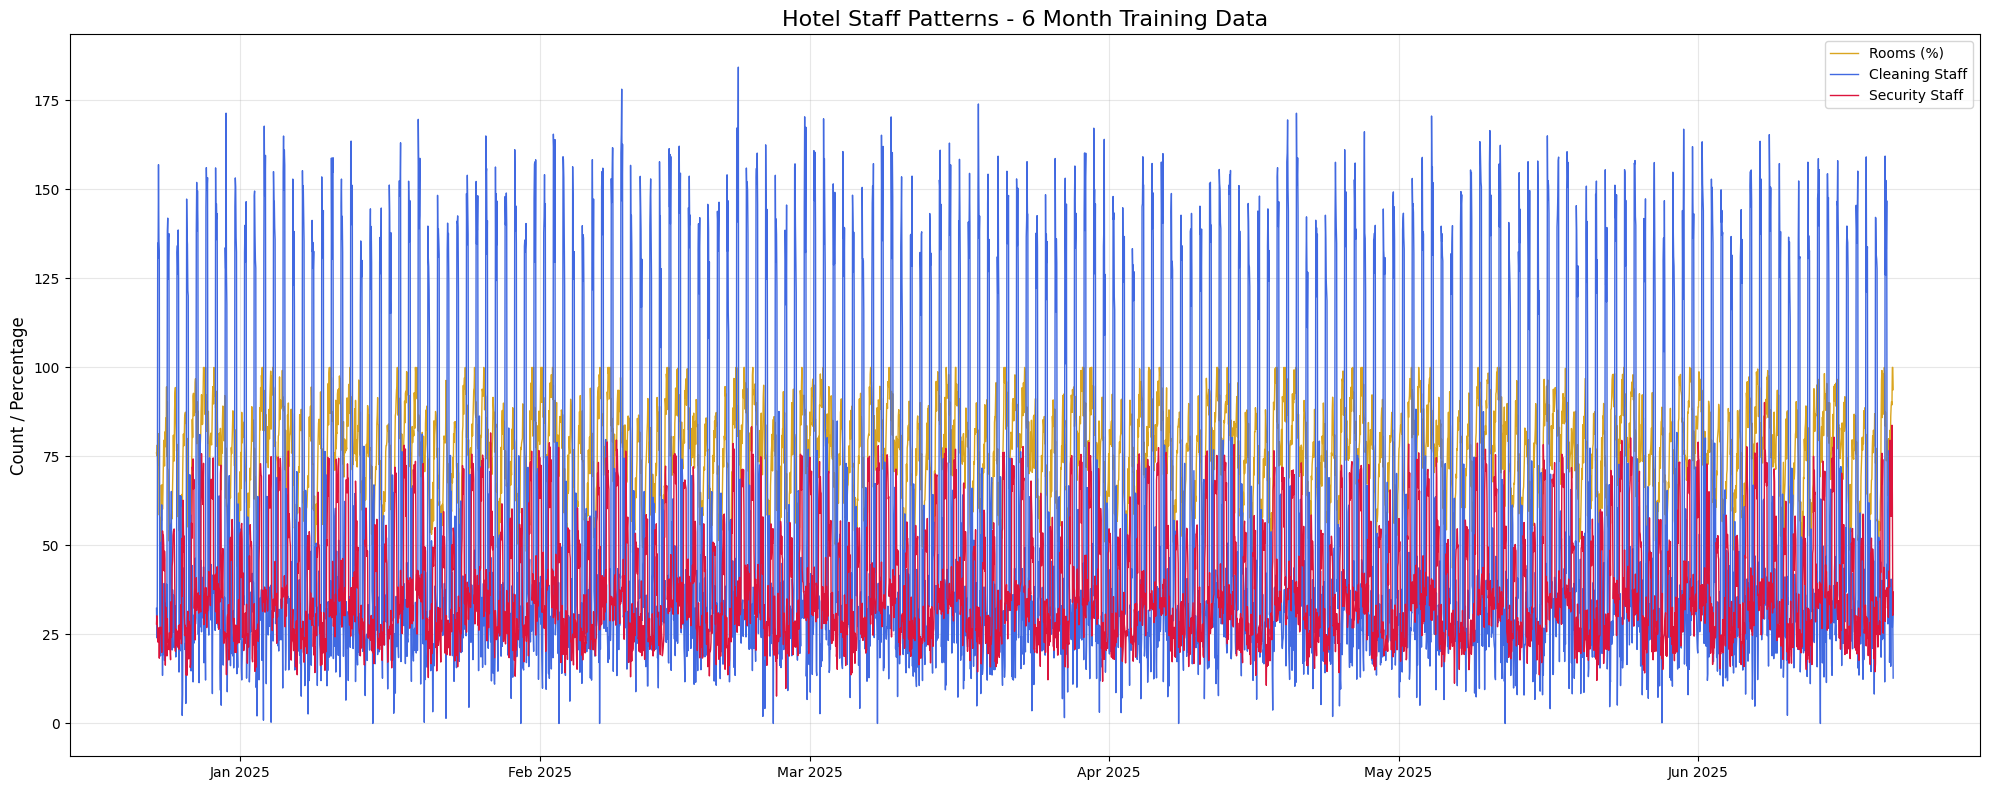

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



### Simple version
plt.figure(figsize=(15, 8))

# Plot last 7 days
data = historical_data.tail(7 * 24)

plt.plot(data['datetime'], data['rooms'], 'goldenrod', linewidth=2, label='Rooms (%)')
plt.plot(data['datetime'], data['cleaning'], 'royalblue', linewidth=2, label='Cleaning Staff')
plt.plot(data['datetime'], data['security'], 'crimson', linewidth=2, label='Security Staff')

plt.title('Hotel Staff Patterns - Past 7 Days')
plt.ylabel('Count / Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Monthly ticks version
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(historical_data['datetime'], historical_data['rooms'], 
        color='goldenrod', linewidth=1, label='Rooms (%)')
ax.plot(historical_data['datetime'], historical_data['cleaning'], 
        color='royalblue', linewidth=1, label='Cleaning Staff')
ax.plot(historical_data['datetime'], historical_data['security'], 
        color='crimson', linewidth=1, label='Security Staff')

# Monthly ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ax.set_title('Hotel Staff Patterns - 6 Month Training Data', fontsize=16)
ax.set_ylabel('Count / Percentage', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Step 2: Preprocess the Data

In [3]:
# Create features
df = historical_data.copy()
df['hour_norm'] = df.datetime.dt.hour / 24
df['day_norm'] = df.datetime.dt.dayofweek / 6
df['hour_sin'] = np.sin(2 * np.pi * df.datetime.dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.datetime.dt.hour / 24)
df['weekend'] = (df.datetime.dt.dayofweek >= 5).astype(float)

# Extract arrays
features = ['hour_norm', 'day_norm', 'hour_sin', 'hour_cos', 'weekend']
targets = ['rooms', 'cleaning', 'security']
X = df[features].values
y = df[targets].values

### /\ /\ /\ From Pandas to Numpy \/ \/ \/

# Create sequences
seq_len = 24
X_seq = np.array([X[i:i+seq_len] for i in range(len(X)-seq_len)])
y_seq = np.array([y[i:i+seq_len] for i in range(len(y)-seq_len)])

# Normalize
X_mean, X_std = X_seq.mean(), X_seq.std()
y_mean, y_std = y_seq.mean(), y_seq.std()
X_seq_norm = (X_seq - X_mean) / X_std
y_seq_norm = (y_seq - y_mean) / y_std

# Split - last 168 hours for validation
val_seqs = 145
X_train, X_val = X_seq_norm[:-val_seqs], X_seq_norm[-val_seqs:]
y_train, y_val = y_seq_norm[:-val_seqs], y_seq_norm[-val_seqs:]

print(f"\nTraining: {len(X_train)} sequences")
print(f"Validation: {len(X_val)} sequences (last 7 days)")
print(f"Shape: {X_train.shape}")


Training: 4151 sequences
Validation: 145 sequences (last 7 days)
Shape: (4151, 24, 5)


## Step 3: Build the Forecast Model

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(20, return_sequences=True),
    Dense(3)
])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
early_stop = EarlyStopping(monitor='accuracy', baseline=0.95)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1, callbacks=[early_stop])
print("Model training complete!")

2025-06-21 06:05:14.564082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 06:05:14.569603: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 06:05:14.595136: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 06:05:14.629653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750485914.668952   67916 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750485914.68

Epoch 1/50


2025-06-21 06:05:16.883516: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6553 - loss: 0.6439 - val_accuracy: 0.9066 - val_loss: 0.2384
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9067 - loss: 0.2405 - val_accuracy: 0.9425 - val_loss: 0.1737
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9369 - loss: 0.1791 - val_accuracy: 0.9589 - val_loss: 0.1405
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9461 - loss: 0.1436 - val_accuracy: 0.9612 - val_loss: 0.1204
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9472 - loss: 0.1207 - val_accuracy: 0.9543 - val_loss: 0.1046
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9491 - loss: 0.1029 - val_accuracy: 0.9489 - val_loss: 0.0926
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9489 - loss: 0.0907 - val_accuracy: 0.9506 - val_loss: 0.0845
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9509 - loss: 0.0826 - val_accuracy: 0.9468 - val_

## Step 4: Generate Forecast

In [5]:
from datetime import timedelta

predictions = []
current = df.tail(24).copy()

for day in range(7):
    # Normalize and predict
    X_norm = (current[features].values - X_mean) / X_std
    pred = model.predict(X_norm[None, :, :], verbose=0)[0] * y_std + y_mean
    
    # Store predictions with timestamps
    start = current.iloc[-1]['datetime']
    for i in range(24):
        t = start + timedelta(hours=i+1)
        predictions.append({
            'datetime': t,
            'rooms': np.clip(pred[i,0], 0, 100),
            'cleaning': max(0, pred[i,1]),
            'security': max(0, pred[i,2])
        })
    
    # Next 24 hours features
    times = pd.date_range(start + timedelta(hours=1), periods=24, freq='h')
    current = pd.DataFrame({
        'datetime': times,
        'hour_norm': times.hour / 24,
        'day_norm': times.dayofweek / 6,
        'hour_sin': np.sin(2 * np.pi * times.hour / 24),
        'hour_cos': np.cos(2 * np.pi * times.hour / 24),
        'weekend': (times.dayofweek >= 5) * 1.0
    })
    
forecast_df = pd.DataFrame(predictions)

## Step 5: Visualize the Forecast

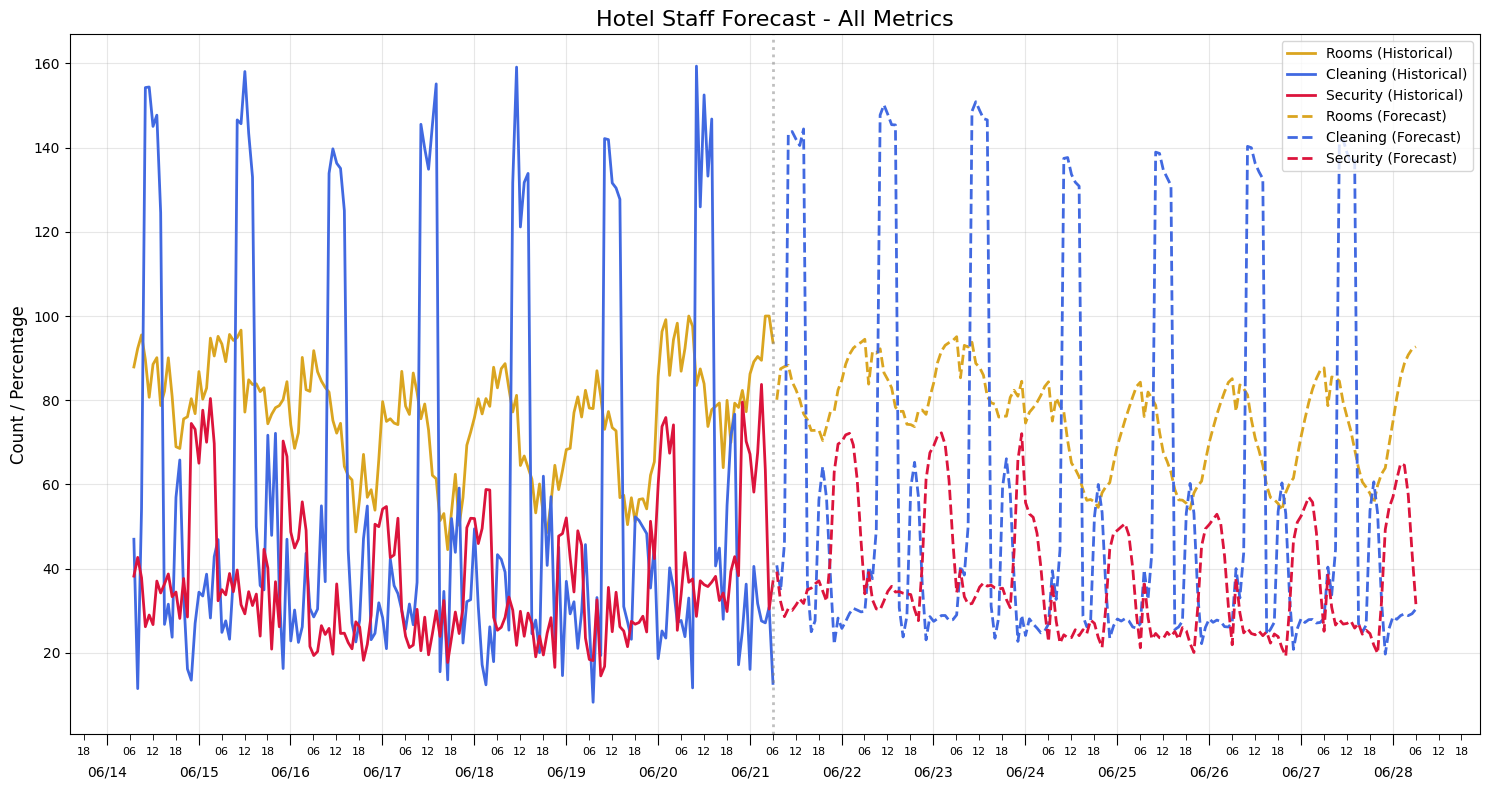

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Get last 7 days of historical data for context
hist_days = 7
hist_tail = historical_data.tail(hist_days * 24)

# Create single plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot historical data (solid lines)
ax.plot(hist_tail['datetime'], hist_tail['rooms'], 
        color='goldenrod', linewidth=2, label='Rooms (Historical)')
ax.plot(hist_tail['datetime'], hist_tail['cleaning'], 
        color='royalblue', linewidth=2, label='Cleaning (Historical)')
ax.plot(hist_tail['datetime'], hist_tail['security'], 
        color='crimson', linewidth=2, label='Security (Historical)')

# Plot forecast data (dashed lines)
ax.plot(forecast_df['datetime'], forecast_df['rooms'], 
        color='goldenrod', linewidth=2, linestyle='--', label='Rooms (Forecast)')
ax.plot(forecast_df['datetime'], forecast_df['cleaning'], 
        color='royalblue', linewidth=2, linestyle='--', label='Cleaning (Forecast)')
ax.plot(forecast_df['datetime'], forecast_df['security'], 
        color='crimson', linewidth=2, linestyle='--', label='Security (Forecast)')

# Add vertical line at transition point
ax.axvline(x=hist_tail['datetime'].iloc[-1], color='gray', alpha=0.5, linestyle=':', linewidth=2)

# Primary x-axis for dates (major ticks)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# Secondary x-axis for hours (minor ticks) - force specific hours
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

# Configure tick appearance
ax.tick_params(axis='x', which='major', pad=15, labelsize=10, length=8)
ax.tick_params(axis='x', which='minor', pad=5, labelsize=8, rotation=0, length=4)

# Formatting
ax.set_title('Hotel Staff Forecast - All Metrics', fontsize=16)
ax.set_ylabel('Count / Percentage', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

# Remove x-label since we have the ticks
ax.set_xlabel('')

plt.tight_layout()
plt.show()

## Step 6: Export Forecast for Frontend

In [7]:
import json

# Direct export without function
frontend_data = {
    'historical': historical_data.tail(168).assign(
        date=lambda x: x.datetime.dt.strftime('%Y-%m-%d %H:%M')
    )[['date', 'rooms', 'cleaning', 'security']].to_dict('records'),
    
    'forecast': forecast_df.assign(
        date=lambda x: x.datetime.dt.strftime('%Y-%m-%d %H:%M')
    )[['date', 'rooms', 'cleaning', 'security']].to_dict('records')
}

# Save
with open('wynn_forecast_data.json', 'w') as f:
    json.dump(frontend_data, f, indent=2)

print(f"Exported {len(frontend_data['historical'])} historical, {len(frontend_data['forecast'])} forecast records")

Exported 168 historical, 168 forecast records


## Summary

We've built a forecasting model that:
1. Generates realistic Vegas hotel and casino patterns like those of Wynn Resort and Casino
2. Trains on historical hourly data
3. Produces 168-hour forecasts
4. Exports data for our frontend

Next steps: Connect this to our WebSocket backend!